In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from hmmlearn.hmm import GaussianHMM

In [5]:
PROJECT_FOLDER = '/Users/emilienprn/Documents/3A/IACHM/music'
DATA_FOLDER = f'{PROJECT_FOLDER}/data'

GESTURES_FOLDER = f'{DATA_FOLDER}/gestures'

gesturesMaster_path = f'{DATA_FOLDER}/gestures.csv'
labelsMaster_path   = f'{DATA_FOLDER}/labels.csv'
movesMaster_path    = f'{DATA_FOLDER}/moves.csv'

In [6]:
df_gestures = pd.read_csv(gesturesMaster_path)
df_labels   = pd.read_csv(labelsMaster_path)
df_moves    = pd.read_csv(movesMaster_path)

df = (df_gestures.merge(df_labels, on='gesture_id') 
                 .merge(df_moves, on='move_id') )

In [51]:
def get_move(description):
    df_moves = pd.read_csv(movesMaster_path)
    if description in df_moves['move_name'].values:
        move_id = df_moves[df_moves['move_name'] == description]['move_id'].values[0]
    else:
        if df_moves.empty:
            move_id = 1
        else:
            move_id = df_moves['move_id'].max() + 1
        new_move = pd.DataFrame({'move_id': [move_id], 'move_name': [description]})
        df_moves = pd.concat([df_moves, new_move], ignore_index=True)
        df_moves.to_csv(movesMaster_path, index=False)
        print(f'created new move "{description}" with id {move_id}.')
    return move_id

def label(gesture_id, move_description):
    move_id = get_move(move_description)
    new_label = pd.DataFrame({'gesture_id': [gesture_id], 'move_id': [move_id]})
    df_labels = pd.read_csv(labelsMaster_path)
    df_labels = df_labels[df_labels['gesture_id'] != gesture_id]
    df_labels = pd.concat([df_labels, new_label], ignore_index=True)
    df_labels.to_csv(labelsMaster_path, index=False)
    print(f'labeled gesture {gesture_id} as move "{move_description}" (id {move_id}).')

def label_last(move_description):
    df_gestures = pd.read_csv(gesturesMaster_path)
    df_labels = pd.read_csv(labelsMaster_path)
    df = df_gestures.merge(df_labels, on='gesture_id', how='left')
    df = df[df['move_id'].isna()]
    if df.empty:
        print('No unlabeled gestures found.')
        return
    last_gesture_id = df_gestures['gesture_id'].max()
    label(last_gesture_id, move_description)

def get_df():
    df_gestures = pd.read_csv(gesturesMaster_path)
    df_labels   = pd.read_csv(labelsMaster_path)
    df_moves    = pd.read_csv(movesMaster_path)
    df = (df_gestures.merge(df_labels, on='gesture_id', how='left') 
                     .merge(df_moves, on='move_id', how='left') )
    return df


def load_gestures(columns=None):
    df = get_df()
    df = df.dropna(subset=['move_name'])

    if columns is None:
        columns = ["accel_x", "accel_y", "accel_z",
                   "gyro_alpha", "gyro_beta", "gyro_gamma",
                   "mag_heading"]
    else:
        assert all(col in df.columns.tolist() for col in columns), "Invalid column names"
    
    d = len(columns)
    data = {'X': [],
            'Y': []}
    for _, row in df.iterrows():
        gesture_path = f'{GESTURES_FOLDER}/gesture_{row["gesture_id"]}.csv'
        gesture_data = pd.read_csv(gesture_path)
        gesture_data = gesture_data[columns].values
        data['X'].append(gesture_data)
        data['Y'].append(row['move_name'])

    return data

def transform(data):
    d = data['X'][0].shape[1]
    X = np.zeros((0, d))
    X_lengths = []
    for gesture_data in data['X']:
        X = np.concatenate((X, gesture_data), axis=0)
        X_lengths.append(len(gesture_data))
    return X, X_lengths

def split(data, train_pct=0.75):
    train_data = {'X': [], 'Y': []}
    test_data  = {'X': [], 'Y': []}
    for move in set(data['Y']):
        indices = [i for i, y in enumerate(data['Y']) if y == move]
        n_gestures = len(indices)
        n_train = int(n_gestures * train_pct)
        for i in indices[:n_train]:
            train_data['X'].append(data['X'][i])
            train_data['Y'].append(data['Y'][i])
        for i in indices[n_train:]:
            test_data['X'].append(data['X'][i])
            test_data['Y'].append(data['Y'][i])
    return train_data, test_data

labelling

In [48]:
move = 'infinity'
label_last(move)

No unlabeled gestures found.


load

In [ ]:
data = load_gestures()
train_data, test_data = split(data, train_pct=0.75)

train

In [71]:
def train(data, n_states=10, covariance_type='full', n_iter=10000, tol=0.000001, algorithm='viterbi'):
    moves = list(set(data['Y']))

    models = {}

    for move in moves:
        print(f'move: {move}')
        data_move = {'X': [], 'Y': []}
        for i, y in enumerate(data['Y']):
            if y == move:
                data_move['X'].append(data['X'][i])
                data_move['Y'].append(data['Y'][i])
        data_move['X'], data_move['X_lengths'] = transform(data_move)

        model = GaussianHMM(n_components    = int(n_states),
                            covariance_type = str(covariance_type),
                            n_iter          = n_iter,
                            tol             = tol,
                            algorithm       = algorithm,
                            verbose         = False).fit(data_move['X'], data_move['X_lengths'])
        models[move] = model
        print()

    return models

In [73]:
models = train(train_data, n_states=20)

Fitting a model with 1099 free scalar parameters with only 413 data points will result in a degenerate solution.
Fitting a model with 1099 free scalar parameters with only 532 data points will result in a degenerate solution.


move: shake

move: infinity



In [99]:
def predict(X):
    predictions = []
    for x in X:
        scores = {}
        for move, model in models.items():
            scores[move] = model.score(x)
        predicted_move = max(scores, key=scores.get)
        predictions.append(predicted_move)
    return predictions

def test(data):
    predictions = predict(data['X'])
    correct = 0
    for i, y in enumerate(data['Y']):
        left_part = f'predicted={predictions[i]}'
        right_part = f'actual={y}'
        print(f'{left_part.ljust(20)} vs {right_part.rjust(20)}')
        if predictions[i] == y:
            correct += 1
    accuracy = correct / len(data['Y'])
    return accuracy

def test_multiples(data_list):
    for split, data in data_list.items():
        print(f'testing on {split} data:')
        accuracy = test(data)
        print(f'Accuracy: {accuracy:.2%}\n')

In [100]:
test_multiples({'train': train_data, 'test': test_data})

testing on train data:
predicted=shake      vs         actual=shake
predicted=shake      vs         actual=shake
predicted=shake      vs         actual=shake
predicted=infinity   vs      actual=infinity
predicted=infinity   vs      actual=infinity
predicted=infinity   vs      actual=infinity
Accuracy: 100.00%

testing on test data:
predicted=shake      vs         actual=shake
predicted=infinity   vs      actual=infinity
Accuracy: 100.00%



other

In [104]:
df = get_df()
df

,gesture_id,client_id,start_ts,file_path,move_id,move_name
0,1,172.20.10.1,2025-11-01 21:52:28,/Users/emilienprn/Documents/3A/IACHM/music/dat...,1,shake
1,3,172.20.10.1,2025-11-01 21:52:37,/Users/emilienprn/Documents/3A/IACHM/music/dat...,1,shake
2,5,172.20.10.1,2025-11-01 21:52:44,/Users/emilienprn/Documents/3A/IACHM/music/dat...,1,shake
3,7,172.20.10.1,2025-11-01 21:52:53,/Users/emilienprn/Documents/3A/IACHM/music/dat...,1,shake
4,9,172.20.10.1,2025-11-01 21:53:05,/Users/emilienprn/Documents/3A/IACHM/music/dat...,2,infinity
5,11,172.20.10.1,2025-11-01 21:53:13,/Users/emilienprn/Documents/3A/IACHM/music/dat...,2,infinity
6,13,172.20.10.1,2025-11-01 21:53:21,/Users/emilienprn/Documents/3A/IACHM/music/dat...,2,infinity
7,15,172.20.10.1,2025-11-01 21:53:53,/Users/emilienprn/Documents/3A/IACHM/music/dat...,2,infinity


In [92]:
def plot(data):
    moves = list(set(data['Y']))
    for move in moves:
        n = data['Y'].count(move)
        d = data['X'][0].shape[1]
        print(f'Gesture: {move}, Count: {n}')

        fig, ax = plt.subplots(n, d, figsize=(15*d, 5*n))
        for i in range(n):
            gesture_data = data['X'][data['Y'].index(move, i)]
            for j in range(d):
                ax[i, j].plot(gesture_data[:, j])
                ax[i, j].set_title(f'{move} n°{i} - dim {j}')
        plt.show()

Gesture: shake, Count: 4


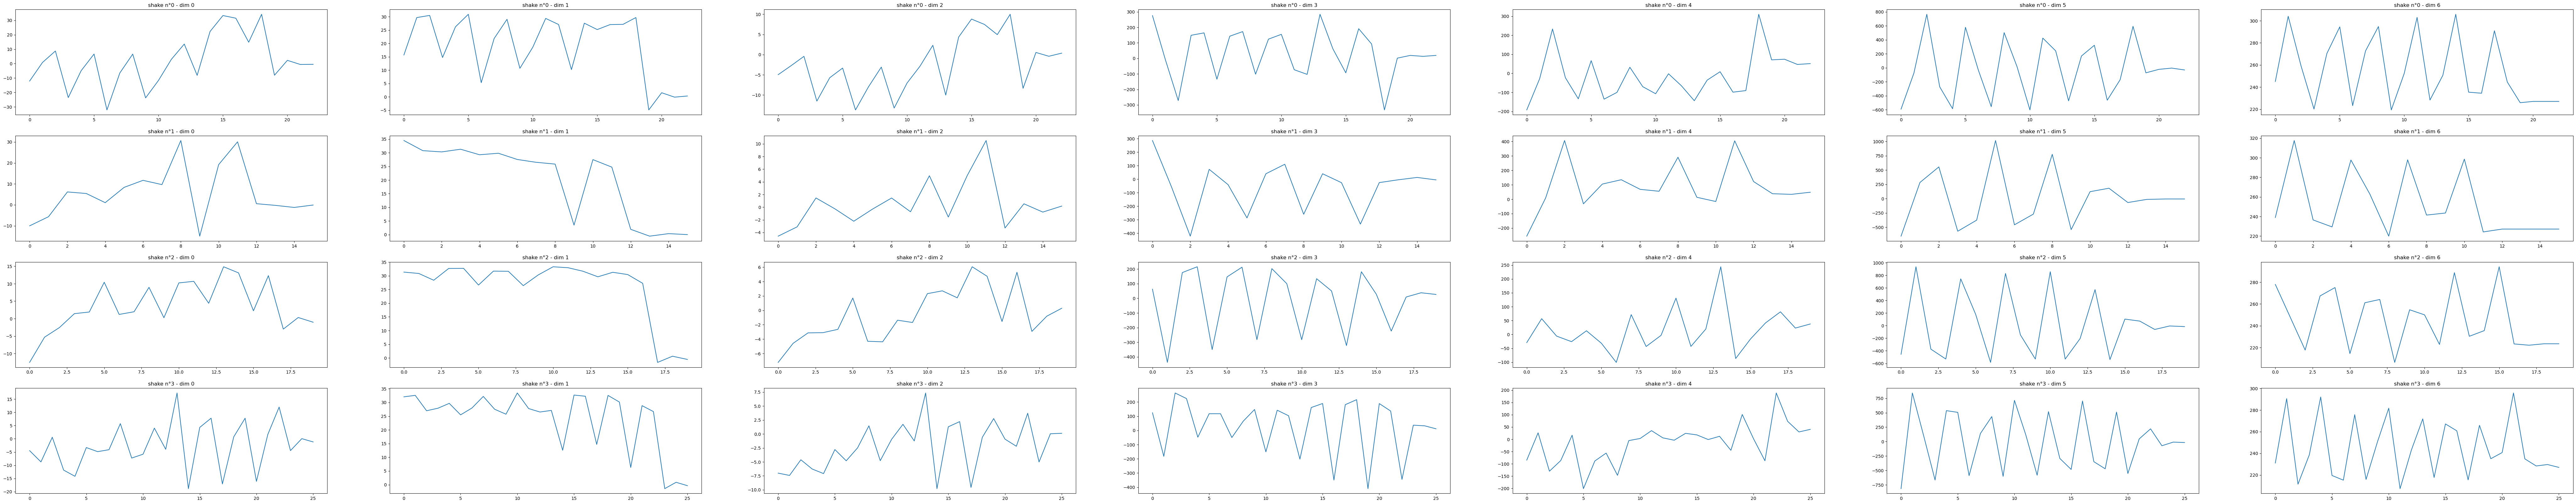

Gesture: infinity, Count: 4


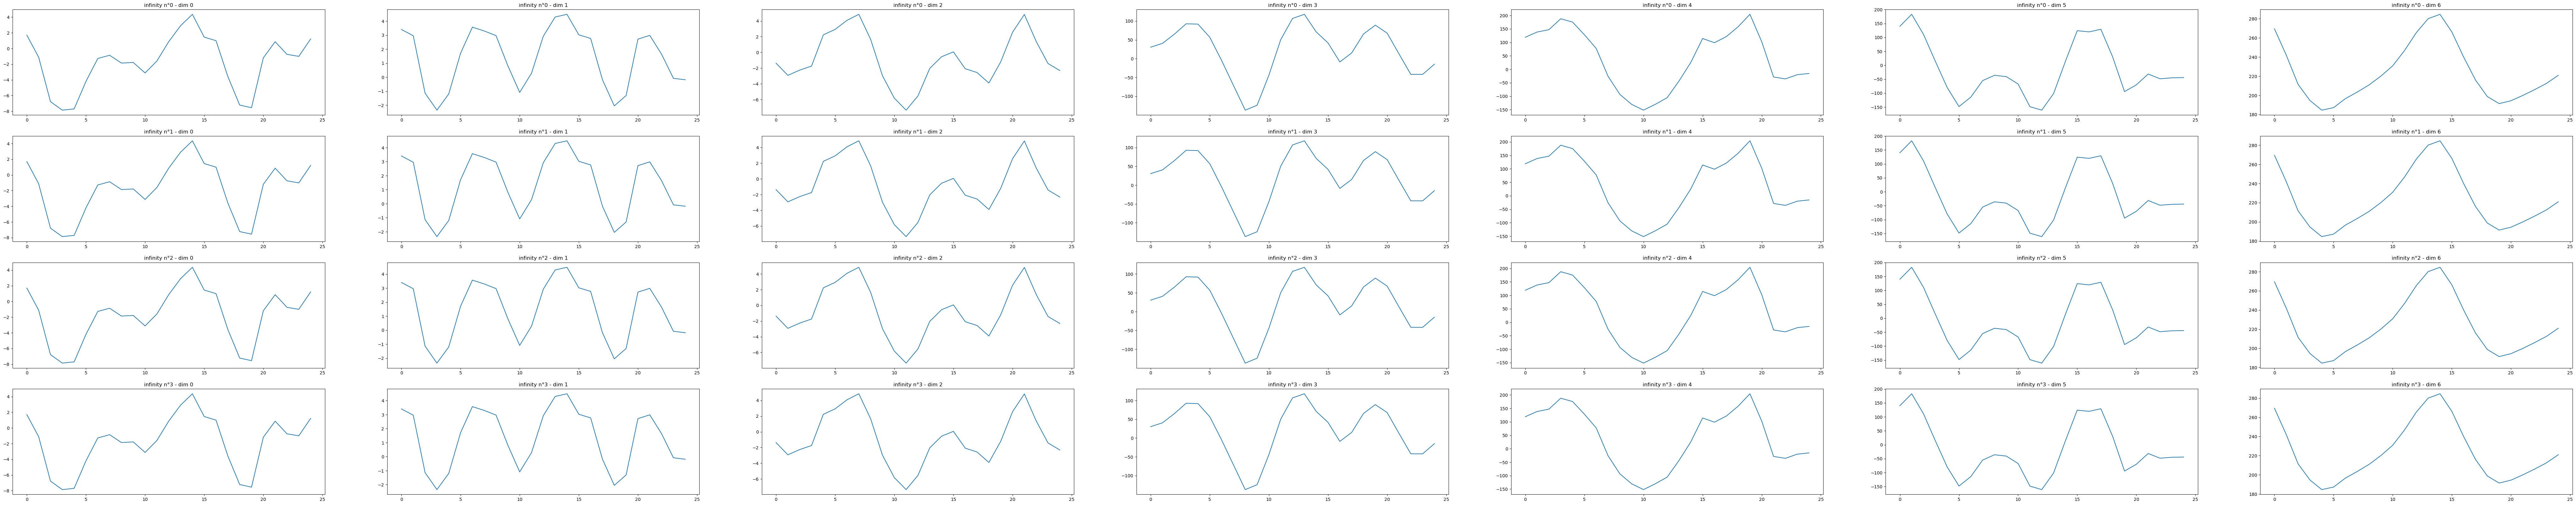

In [93]:
plot(data)